## Segmenting single-cells

Segment foreground masks and single-cells using an exisiting cellpose model and save into h5 format for trajectory modeling and analysis

In [1]:
%%capture
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/groups/ZuckermanLab/copperma/cell/celltraj/celltraj')
import imageprep as imprep
import utilities
import pickle
import tifffile
import skimage.filters
import scipy.ndimage
import csaps
from skimage.filters import threshold_local
from skimage.segmentation import watershed
from skimage.segmentation import clear_border
from skimage.feature import peak_local_max
from skimage import transform as tf
import pyemma.coordinates
from sklearn.mixture import GaussianMixture
from scipy.ndimage import generic_filter
from cellpose import models
import cmapfile
import pathlib
import nd2
from skimage.measure import regionprops_table
from IPython.display import clear_output
import os
#import dask.array as da
#import dask_image.imread
ndimage=scipy.ndimage

##### Establish channels, imaging parameters, and object parameters-- use NIS AR or other software first to gather info, copy from extract_roi step

In [2]:
date = '2024.03.08'
modelName = f'20240302_OS17lung_RM' #results will be saved/named using this string
nxy=20
ind_xy = np.arange(nxy).astype(int)
#ind_xy = np.array([3,4]).astype(int) #choose xys for analysis. If all, use ind_xy = np.arange(nxy).astype(int)
nuc_channel=0 #nuclear channel
rep_channel=3 #reporter channel (ERK here)
bf_channel=4 #bright-field channel
channels = ['DAPI','CFP','TRITC','YFP','BF'] #names for channels in plots
channel_colors = ['blue','cyan','red','goldenrod','gray'] #colors for channels in plots
channel_dict=dict([(x, i) for i, x in enumerate(channels)])
micron_per_pixel=.33 #lateral resolution (image pixel size)
micron_per_z=3.0 #axial resolution between z-slices
zscale=micron_per_z/micron_per_pixel
nucl=40 #typical nucleus linear diameter pixels
nt=73 #number of frames, used for testing intensity ratios to decide whether to segment an ROI

In [3]:
#some convenience functions here, eventually these will be incorporated into the packages....
def show_image_3channel(bf_img,nuc_img,rep_img,ax=None):
        if ax is None:
            ax=plt.gca()
        ax.imshow(imprep.znorm(bf_img),cmap=plt.cm.binary,clim=(-5,5))
        cs=ax.contour(imprep.znorm(nuc_img),cmap=plt.cm.BuPu,levels=np.linspace(0,np.percentile(imprep.znorm(nuc_img),99),7),alpha=.5,linewidths=.5)
        cs.cmap.set_over('purple')
        cs=ax.contour(imprep.znorm(rep_img),cmap=plt.cm.YlOrBr_r,levels=np.linspace(0,np.percentile(imprep.znorm(rep_img),99),7),alpha=.25,linewidths=.5)
        cs.cmap.set_over('yellow')
        return ax

def rescale_to_int(img,maxint=255,dtype=np.uint16):
    img=maxint*((img-np.min(img))/np.max(img-np.min(img)))
    return img.astype(dtype)

def show_3dseg_zproj(fig,im3d,labels,fmap=None,fmapscale=None,labels2=None,fmsk=None):
    zproj=np.sum(im3d,axis=0)
    labels_zproj=np.max(labels,axis=0)
    plt.imshow(zproj,cmap=plt.cm.gray_r)
    plt.contour(labels_zproj,levels=np.arange(np.max(labels_zproj)),colors='blue',linewidths=1)
    if fmap is not None:
        #plt.contour(np.max(fmap,axis=0),levels=np.linspace(np.min(fmap),np.max(fmap),21),cmap=plt.cm.PiYG_r)
        plt.imshow(np.max(fmap,axis=0),cmap=plt.cm.YlOrRd,alpha=.33,clim=fmapscale)
    if labels2 is not None:
        labels2_zproj=np.max(labels2,axis=0)
        plt.contour(labels2_zproj,levels=np.arange(np.max(labels2_zproj)),colors='green',linewidths=1)
    if fmsk is not None:
        fmsk_zproj=np.max(fmsk,axis=0)
        plt.contour(fmsk_zproj,levels=np.arange(np.max(fmsk_zproj)),colors='red',linewidths=1)    
    plt.axis('equal');plt.axis('off')

def log_ztransform(img):
    img=np.log(imprep.znorm(img)+1.-np.min(imprep.znorm(img)))
    return img

def nuc_viewtransform(im3d_nuc,zcut_nuc=2.0,rsmooth=1.0,zscale=5.0):
    im3d_nuc=skimage.filters.gaussian(im3d_nuc,sigma=[rsmooth/zscale,rsmooth,rsmooth])
    im3d_nuc=imprep.znorm(im3d_nuc)
    im3d_nuc[im3d_nuc<zcut_nuc]=0
    im3d_nuc=rescale_to_int(log_ztransform(im3d_nuc))
    return im3d_nuc

def bf_viewtransform(im3d_bf,rsmooth=10.0,zscale=5.0,zcut=2.0,remove_background=False):
    im3d_bf=skimage.filters.difference_of_gaussians(im3d_bf,.5,1.5)
    if remove_background:
        im3d_bf_smth=skimage.filters.gaussian(np.abs(im3d_bf),sigma=[rsmooth/zscale,rsmooth,rsmooth])
        msk_bf=imprep.znorm(im3d_bf_smth)>zcut
        msk_bf=binary_fill_holes_2dstack(msk_bf)
    im3d_bf=rescale_to_int(log_ztransform(im3d_bf))
    im3d_bf=np.max(im3d_bf)-im3d_bf
    if remove_background:
        im3d_bf[np.logical_not(msk_bf)]=0
    return im3d_bf

def rep_viewtransform(im3d_rep,rsmooth=1.0,zscale=5.0):
    im3d_rep=skimage.filters.gaussian(im3d_rep,sigma=[rsmooth/zscale,rsmooth,rsmooth])
    im3d_rep=rescale_to_int(log_ztransform(im3d_rep))
    return im3d_rep

def binary_fill_holes_2dstack(im3d):
    for iz in range(im3d.shape[0]):
        im3d[iz,...]=ndimage.binary_fill_holes(im3d[iz,...])
    return im3d

##### Segmentation loop

In [62]:
visual=True; live_render=True #setting parameters and paths for segmentation
vizpath='/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM/seg_imgs'
pathexists = os.path.isdir(vizpath) #create image folder if it doesn't exist already
if not pathexists:
    os.mkdir(vizpath)
datapath='/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM'
int_cut=1.05
highlow_perc=.1
nt_train=5; nt
train_frames=np.linspace(0,nt-1,nt_train).astype(int)
cellpose_modelpath='/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM/cellpose_trainingdata/models/tissuenet_20240302_OS17lung_RM_12mar24_3'
model = models.CellposeModel(gpu=True,pretrained_model=cellpose_modelpath)
cellpose_channels = [[1,2]]
cellprob_threshold=0.
minsize=int(np.pi*(nucl/2.)**2) #at least one nuclear slices
maxsize=int(((8*nucl)**3)/zscale)
cellpose_diam=54.0 #from mean mask size in training
rsmooth=nucl/4
rsmooth_nuc=nucl/10
visual=True
zcut=1.0
zcut_nuc=2.
mask_channels=['cyto','nuc','foreground']
fmskchannel=2
mskchannel=0
nmaskchannels=len(mask_channels)

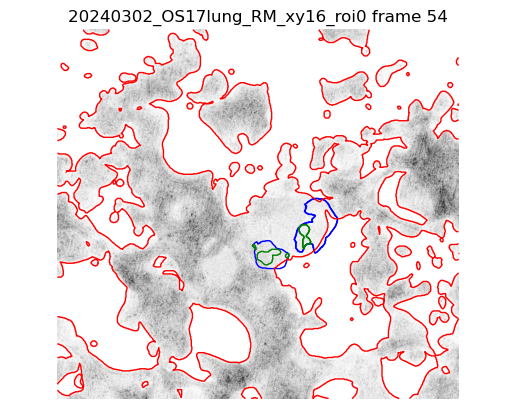

In [ ]:
empty_array=np.array([])
for ixy in ind_xy:
    imagelist = imprep.list_images(f'{datapath}/{modelName}_XY{ixy}_roi*.tif')
    n_rois=len(imagelist)
    for i_roi in range(n_rois):
        moviename=f'{modelName}_xy{ixy}_roi{i_roi}'
        imgs_roi=skimage.io.imread(imagelist[i_roi])
        nt_roi,nz_roi,nx_roi,ny_roi,nchannels_roi=imgs_roi.shape
        int_low=np.percentile(imgs_roi[train_frames,...],highlow_perc,axis=(0,1,2,3))
        int_high=np.percentile(imgs_roi[train_frames,...],100.-highlow_perc,axis=(0,1,2,3))
        int_ratio=np.divide(int_high,int_low)
        print(f'{moviename} int ratio {int_ratio[0]:.2f},{int_ratio[1]:.2f},{int_ratio[2]:.2f}')
        if (int_ratio<int_cut).any():
            print(f"Intensity high/low percentile ratios {int_ratio[rep_channel]:.2f},{int_ratio[nuc_channel]:.2f},{int_ratio[bf_channel]:.2f} less than specified cutoff {int_cut}: xy{ixy} roi{i_roi}")
        else:
            h5filename=f'{moviename}.h5'
            metadata_dict = {
              "axes": 'zxyc',
              "nt": nt_roi,
              "nz": nz_roi,
              "nx": nx_roi,
              "ny": ny_roi,
              "channels": np.array(channels),
              "mask_channels": np.array(mask_channels),
              "micron_per_pixel": micron_per_pixel,
              "micron_per_z": micron_per_z,
              "zscale": zscale,
              "figid": moviename,
              "imagelist": imagelist[i_roi],
              "nuc_channel": nuc_channel,
              "rep_channel": rep_channel,
              "cellpose_modelpath": cellpose_modelpath,
              "cellpose_channels": cellpose_channels,
              "minsize": minsize,
              "maxsize": maxsize,
              "cellpose_diam": cellpose_diam,
              "mask_channels": mask_channels,
              "fmskchannel": fmskchannel,
              "mskchannel": mskchannel,
              "nmaskchannels": nmaskchannels
            }
            imprep.create_h5(h5filename,metadata_dict)
            for iS in range(0,nt_roi):
                if visual:
                    plt.figure(1)
                    plt.clf();
                img=imgs_roi[iS,...].astype(float)
                #im3d_nuc=nuc_viewtransform(img[...,nuc_channel],rsmooth=nucl/16.,zscale=zscale,zcut_nuc=zcut_nuc)
                #im3d_rep=rep_viewtransform(img[...,rep_channel],rsmooth=1.0,zscale=zscale)
                #im3d_bf=bf_viewtransform(img[...,bf_channel],rsmooth=nucl/4.,zscale=zscale,zcut=zcut)
                im3d_nuc=rescale_to_int(imprep.znorm(img[...,nuc_channel]))
                im3d_rep=rescale_to_int(imprep.znorm(img[...,rep_channel]))
                im3d_bf=imprep.znorm(img[...,bf_channel])
                im3d_bf=skimage.filters.difference_of_gaussians(im3d_bf,.5,1.5)
                im3d_bf=rescale_to_int(im3d_bf)
                cellpose_img=np.zeros((nz_roi,3,nx_roi,ny_roi)).astype(np.uint16)
                cellpose_img[:,0,:,:]=im3d_bf #add in nuc so not hollow
                cellpose_img[:,1,:,:]=im3d_rep
                cellpose_img[:,2,:,:]=im3d_nuc
                #masks, flows, styles = model.eval(cellpose_img, diameter=cellpose_diam, channels=cellpose_channels,do_3D=True,anisotropy=zscale,min_size=minsize)
                masks, flows, styles = model.eval(cellpose_img, diameter=cellpose_diam, channels=cellpose_channels,do_3D=False,anisotropy=zscale,min_size=minsize,stitch_threshold=.1,cellprob_threshold=cellprob_threshold)
                img_bf=img[:,:,:,bf_channel]
                img_bf_dog=skimage.filters.difference_of_gaussians(imprep.znorm(img_bf),.5,1.5)
                img_bf_smth=skimage.filters.gaussian(np.abs(img_bf_dog),sigma=[rsmooth/zscale,rsmooth,rsmooth])
                fmsk=imprep.znorm(img_bf_smth)>zcut
                img_nuc_smth=skimage.filters.gaussian(img[...,nuc_channel],sigma=[rsmooth_nuc/zscale,rsmooth_nuc,rsmooth_nuc])
                img_rep_smth=skimage.filters.gaussian(img[...,rep_channel],sigma=[rsmooth/zscale,rsmooth,rsmooth])
                #nucmsk=imprep.znorm(img[...,nuc_channel])>nuc_cut
                nucmsk=imprep.local_threshold(img_nuc_smth,block_size=imprep.make_odd(2*nucl),z_std=zcut_nuc)
                repmsk=imprep.local_threshold(img_rep_smth,block_size=imprep.make_odd(2*nucl),z_std=zcut_nuc)
                fmsk=np.logical_or(fmsk,repmsk);fmsk=np.logical_or(fmsk,nucmsk)
                fmsk=binary_fill_holes_2dstack(fmsk)
                labels_cyto=imprep.clean_labeled_mask(masks,minsize=minsize,maxsize=maxsize,fill_holes=True,selection='largest') #,test_map=nucmsk,test_cut=nucl,verbose=True)
                labels_nuc=labels_cyto.copy()
                labels_nuc[np.logical_not(nucmsk)]=0
                labels_nuc[np.logical_not(fmsk)]=0
                #labels_cyto_only=imprep.get_cyto_minus_nuc_labels(labels_cyto,labels_nuc)
                if np.sum(labels_cyto)==0:
                    empty_array=np.append(empty_array,f'{h5filename} frame {iS}')
                    print(f'no cells segmented {h5filename} frame {iS}')
                if visual and np.sum(labels_cyto>0):
                    clear_output(wait=True);
                    try:
                        plt.figure(1)
                        plt.clf()
                        img_bf_dog=np.abs(imprep.znorm(img_bf_dog))
                        img_bf_dog[np.logical_not(fmsk)]=0
                        show_3dseg_zproj(plt.figure(1),img_bf_dog,labels_cyto,labels2=labels_nuc,fmsk=fmsk) #,fmap=im3d_reporter_ratio,fmapscale=(0,3))
                        plt.title(f'{moviename} frame {iS}');
                        plt.savefig(f'{vizpath}/zproj_{moviename}_f{iS:04d}.png')
                        if live_render:
                            plt.pause(.1)
                    except Exception as e:
                        print(e)
                label=np.zeros((nz_roi,nx_roi,ny_roi,3)).astype(imgs_roi.dtype)
                label[:,:,:,0]=labels_cyto
                label[:,:,:,1]=labels_nuc
                label[:,:,:,2]=fmsk
                img=np.zeros((nz_roi,nx_roi,ny_roi,3))
                img[:,:,:,0]=imgs_roi[iS,...,bf_channel]
                img[:,:,:,1]=imgs_roi[iS,...,nuc_channel]
                img[:,:,:,2]=imgs_roi[iS,...,rep_channel]
                imprep.save_frame_h5(h5filename,iS,img=img,msks=label,fmsk=None,overwrite=True,timestamp=None)

np.savetxt('empty_list.txt',empty_array)

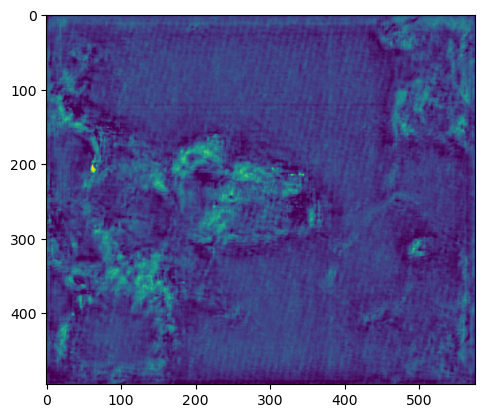

In [53]:
plt.imshow(flows[0][9,:,:,2])

In [63]:
masks, flows, styles = model.eval(cellpose_img, diameter=cellpose_diam, channels=cellpose_channels,do_3D=False,anisotropy=zscale,min_size=minsize,stitch_threshold=.1,cellprob_threshold=-5)

In [64]:
np.sum(masks)

299430

In [59]:
cellpose_channels

[[0, 1]]

In [61]:
model.diam

30.0